#Dependencies

In [ ]:
# Wrapping the cell output

from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))


get_ipython().events.register('pre_run_cell', set_css)

In [ ]:
%%capture
!pip install contextualized-topic-models

In [ ]:
import glob
import re
from math import log10, ceil
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


#Data preparation

In [ ]:
raw_files = glob.glob(r"/content/drive/MyDrive/BigData/data_raw/*.txt")
print(raw_files)

files = glob.glob(r"/content/drive/MyDrive/BigData/data_hashed/*.txt")


def chunking_line_per_txt(max_seq_length=512):
  global raw_files
  max_files = 9999
  i = 1

  for file in raw_files:
      with open(file, 'r', encoding='utf-8') as f:
          content = f.readlines()
          content = [line.replace("\n", "") for line in content]
          content = "".join(content).split(' ')

      tokens = len(content)

      chunks = [" ".join(content[x:x + max_seq_length]) for x in
                range(0, tokens, max_seq_length)]

      for chunk in chunks:
          if i == 1:
              zeros = "000"
          elif ceil(log10(i)) == log10(i):
              zeros = (ceil(log10(max_files)) - ceil(log10(i)) - 1) * "0"
          else:
              zeros = (ceil(log10(max_files)) - ceil(log10(i))) * "0"
          write_path = fr"/content/drive/MyDrive/BigData/data_hashed/line_{zeros}{i}.txt"

          with open(write_path, 'w', encoding='utf-8') as f:
              f.write(chunk)

          i += 1


def glue_files_together(write_path):
  global files
  with open(write_path, 'w') as f:
      f.write("")

  for file in files:
      with open(file, 'r', encoding='utf-8') as f:
          content = f.readlines()

      with open(write_path, 'a', encoding='utf-8') as f:
          for con in content:
              f.write(con + '\n')

['/content/drive/MyDrive/BigData/data_raw/06-pan-wolodyjowski.txt', '/content/drive/MyDrive/BigData/data_raw/02-ogniem-i-mieczem-tom-drugi.txt', '/content/drive/MyDrive/BigData/data_raw/01-ogniem-i-mieczem-tom-pierwszy.txt', '/content/drive/MyDrive/BigData/data_raw/03-potop-tom-pierwszy.txt', '/content/drive/MyDrive/BigData/data_raw/04-potop-tom-drugi.txt', '/content/drive/MyDrive/BigData/data_raw/05-potop-tom-trzeci.txt']


In [ ]:
write_path = "/content/drive/MyDrive/BigData/corpus_512_words_per_line_trylogia.txt"

chunking_line_per_txt()
glue_files_together(write_path)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#Data preprocessing

In [ ]:
# Custom stopwords preprocessing

from sklearn.feature_extraction.text import CountVectorizer
import string
from nltk.corpus import stopwords as stop_words
import warnings


class WhiteSpacePreprocessingStopwords():
    """
    Provides a very simple preprocessing script that filters infrequent tokens from text
    """

    def __init__(self, documents, stopwords_list=None, vocabulary_size=2000, max_df=1.0, min_words=1,
                 remove_numbers=True):
        """
        :param documents: list of strings
        :param stopwords_list: list of the stopwords to remove
        :param vocabulary_size: the number of most frequent words to include in the documents. Infrequent words will be discarded from the list of preprocessed documents
        :param max_df : float or int, default=1.0
        When building the vocabulary ignore terms that have a document
        frequency strictly higher than the given threshold (corpus-specific
        stop words).
        If float in range [0.0, 1.0], the parameter represents a proportion of
        documents, integer absolute counts.
        This parameter is ignored if vocabulary is not None.
        :param min_words: int, default=1. Documents with less words than the parameter
        will be removed
        :param remove_numbers: bool, default=True. If true, numbers are removed from docs
        """
        self.documents = documents
        if stopwords_list is not None:
            self.stopwords = set(stopwords_list)
        else:
            self.stopwords = []

        self.vocabulary_size = vocabulary_size
        self.max_df = max_df
        self.min_words = min_words
        self.remove_numbers = remove_numbers
        print(stopwords)

    def preprocess(self):
        """
        Note that if after filtering some documents do not contain words we remove them. That is why we return also the
        list of unpreprocessed documents.
        :return: preprocessed documents, unpreprocessed documents and the vocabulary list
        """
        preprocessed_docs_tmp = self.documents
        preprocessed_docs_tmp = [doc.lower() for doc in preprocessed_docs_tmp]
        preprocessed_docs_tmp = [doc.translate(
            str.maketrans(string.punctuation, ' ' * len(string.punctuation))) for doc in preprocessed_docs_tmp]
        if self.remove_numbers:
            preprocessed_docs_tmp = [doc.translate(str.maketrans("0123456789", ' ' * len("0123456789")))
                                     for doc in preprocessed_docs_tmp]
        preprocessed_docs_tmp = [' '.join([w for w in doc.split() if len(w) > 0 and w not in self.stopwords])
                                 for doc in preprocessed_docs_tmp]

        vectorizer = CountVectorizer(max_features=self.vocabulary_size, max_df=self.max_df)
        vectorizer.fit_transform(preprocessed_docs_tmp)
        temp_vocabulary = set(vectorizer.get_feature_names_out())

        preprocessed_docs_tmp = [' '.join([w for w in doc.split() if w in temp_vocabulary])
                                 for doc in preprocessed_docs_tmp]

        preprocessed_docs, unpreprocessed_docs, retained_indices = [], [], []
        for i, doc in enumerate(preprocessed_docs_tmp):
            if len(doc) > 0 and len(doc) >= self.min_words:
                preprocessed_docs.append(doc)
                unpreprocessed_docs.append(self.documents[i])
                retained_indices.append(i)

        vocabulary = list(set([item for doc in preprocessed_docs for item in doc.split()]))

        return preprocessed_docs, unpreprocessed_docs, vocabulary, retained_indices


In [ ]:
%%capture
max_seq_len = 512
text_file = "/content/drive/MyDrive/BigData/corpus_lemmatized.txt"

stopwords_path = '/content/drive/MyDrive/BigData/stopwords.txt'

documents = [line.strip() for line in open(text_file, encoding="utf-8").readlines()]

documents_cl_fin = []
documents_cl = [re.sub(" [.,:;\"'?!()]*[a-żA-Ż]{1,3}[.,:;\"'?!()]* ", " ", line) for line in documents]
for i in range(len(documents_cl)):
  documents_cl_fin.append(' '.join([w for w in documents_cl[i].split(' ') if len(w)>3]))

with open(stopwords_path, 'r') as f:
  stopwords = f.readlines()

stopwords = [line.replace("\n", "") for line in stopwords]

sp = WhiteSpacePreprocessingStopwords(documents_cl_fin, stopwords_list=stopwords)
preprocessed_documents, unpreprocessed_corpus, vocab, retained_indices = sp.preprocess()

In [ ]:
with open(text_file, "r") as f:
  content = f.readlines()

print("content: " + str(len(content)))

with open(stopwords_path, 'r') as f:
  stop_count = f.readlines()

print("Stopwords: " + str(len(stop_count)))

content: 1531
Stopwords: 585


#Model Training

In [ ]:
from contextualized_topic_models.models.ctm import CombinedTM
from contextualized_topic_models.utils.data_preparation import TopicModelDataPreparation

In [ ]:
tp = TopicModelDataPreparation("dkleczek/bert-base-polish-uncased-v1", max_seq_length=max_seq_len)

training_dataset = tp.fit(text_for_contextual=unpreprocessed_corpus, text_for_bow=preprocessed_documents)

Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/dkleczek_bert-base-polish-uncased-v1 were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
ctm = CombinedTM(bow_size=len(tp.vocab), contextual_size=768, n_components=8, num_epochs=10)
ctm.fit(training_dataset)

Epoch: [10/10]	 Seen Samples: [14720/15310]	Train Loss: 1248.9132876188858	Time: 0:00:00.590592: : 10it [00:05,  1.67it/s]
100%|██████████| 24/24 [00:00<00:00, 41.82it/s]


In [ ]:
# Utility cell to create tables for report
import csv

csv_file = "/content/drive/MyDrive/BigData/words.csv"

topics = ctm.get_topic_lists(15)
fields = ["Word", "Probability"]
rows = []
for i in range(len(topics)):
  words = ctm.get_word_distribution_by_topic_id(i)
  rows.append([])
  rows.append([f"Topic {i + 1}"])
  rows.append(["Word", "Probability"])
  for word in words[:15]:
    rows.append([word[0], round(float(word[1]), 10)])

with open(csv_file, 'w') as f:
  csvwriter = csv.writer(f)
  csvwriter.writerow(fields)
  csvwriter.writerows(rows)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
topics = ctm.get_topic_lists(15)

for i in range(len(topics)):
  words = ctm.get_word_distribution_by_topic_id(i)
  print("\n" + 20*"-" + f" Topic {i + 1} " + 20*"-")
  print("\nWord:          |   Probability:")
  print(42*"-")
  for word in words[:15]:
    print(f"{word[0]:15}|   {round(float(word[1]), 10)}")
  print()
  print(49*"-" + "\n")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



-------------------- Topic 1 --------------------

Word:          |   Probability:
------------------------------------------
ziemia         |   0.0005747277
krzyk          |   0.0005718602
naprzód        |   0.0005717974
lecieć         |   0.0005702287
stado          |   0.0005701381
ogień          |   0.0005675307
pierś          |   0.0005665026
chorągiew      |   0.0005660192
widocznie      |   0.0005657251
twarz          |   0.0005632696
pułk           |   0.0005630965
koński         |   0.0005623213
dziki          |   0.0005622869
słońce         |   0.0005604929
skoczyć        |   0.000559614

-------------------------------------------------


-------------------- Topic 2 --------------------

Word:          |   Probability:
------------------------------------------
szlachta       |   0.000597098
rzeczpospolita |   0.0005934468
szwed          |   0.0005837157
przeciw        |   0.0005758674
królewski      |   0.000571505
wojewoda       |   0.0005707125
wieść          |   0.0005

#Visualisation

In [ ]:
#Custom wordcloud overwrite
import matplotlib.pyplot as plt
import wordcloud

def func(
    self, topic_id, save_path, n_words=5, background_color="black", width=1000, height=400
):
    """
    Plotting the wordcloud. It is an adapted version of the code found here:
    http://amueller.github.io/word_cloud/auto_examples/simple.html#sphx-glr-auto-examples-simple-py and
    here https://github.com/ddangelov/Top2Vec/blob/master/top2vec/Top2Vec.py

    :param topic_id: id of the topic
    :param n_words: number of words to show in word cloud
    :param background_color: color of the background
    :param width: width of the produced image
    :param height: height of the produced image
    """
    word_score_list = self.get_word_distribution_by_topic_id(topic_id)[:n_words]
    word_score_dict = {tup[0]: tup[1] for tup in word_score_list}
    plt.figure(figsize=(10, 4), dpi=200)
    plt.axis("off")
    plt.imshow(
        wordcloud.WordCloud(
            width=width, height=height, background_color=background_color
        ).generate_from_frequencies(word_score_dict)
    )
    plt.title("Displaying Topic " + str(topic_id + 1), loc="center", fontsize=24)
    plt.savefig(save_path, transparent=False)
    plt.show()


CombinedTM.save_wordcloud = func

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


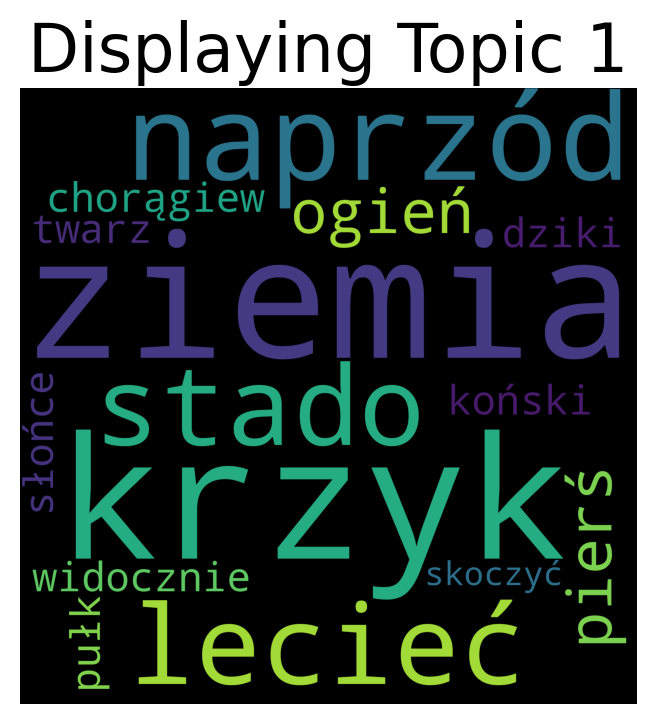

/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


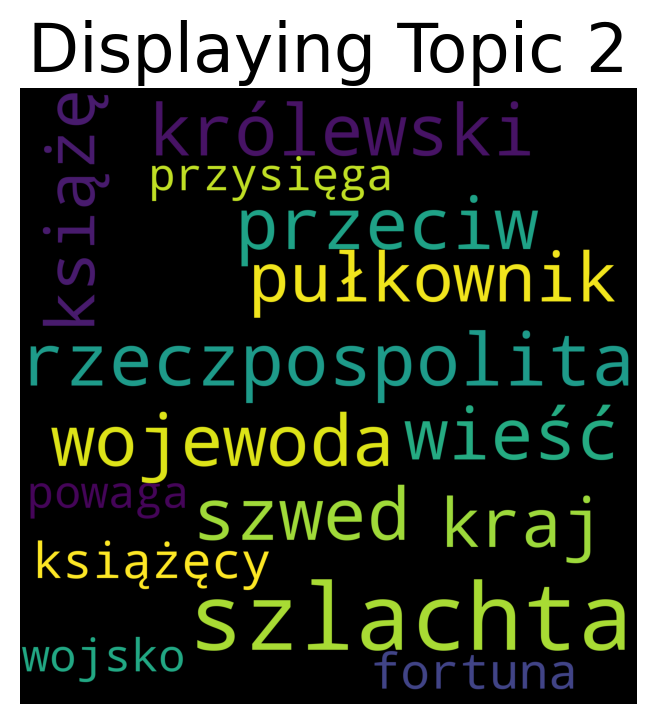

/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


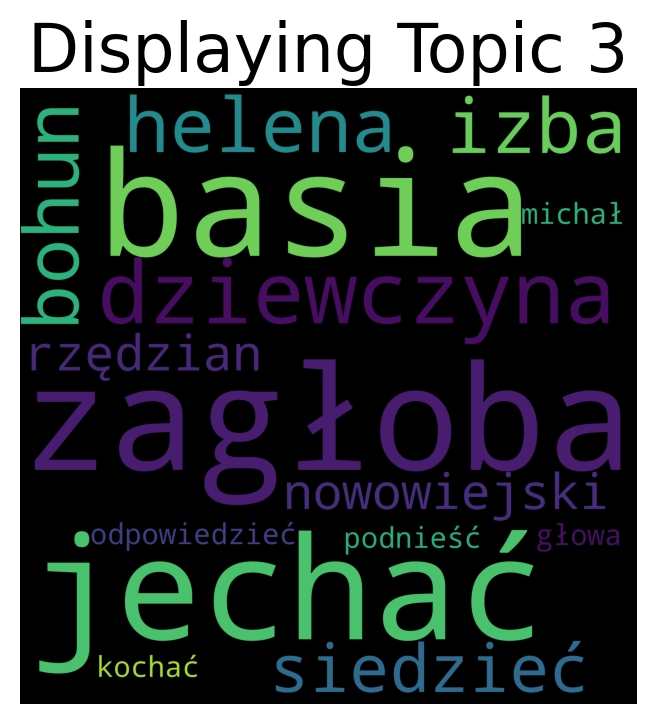

/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


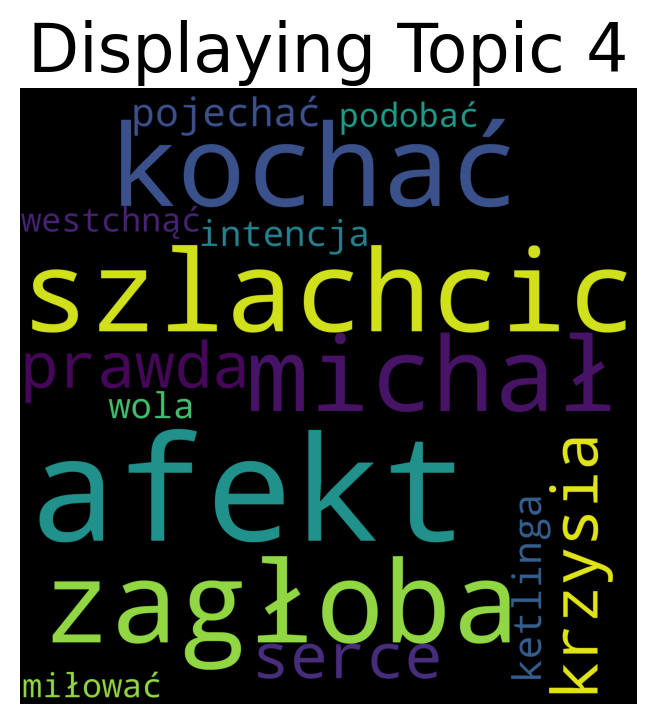

/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


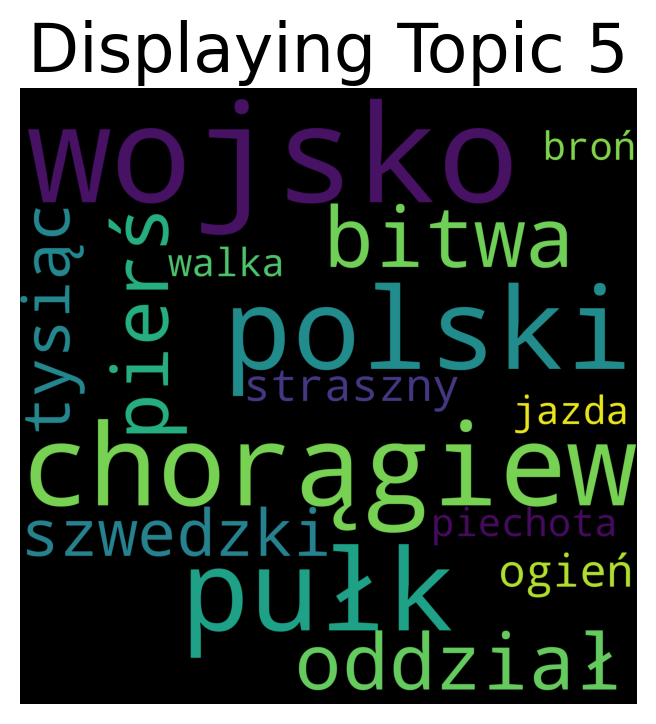

/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


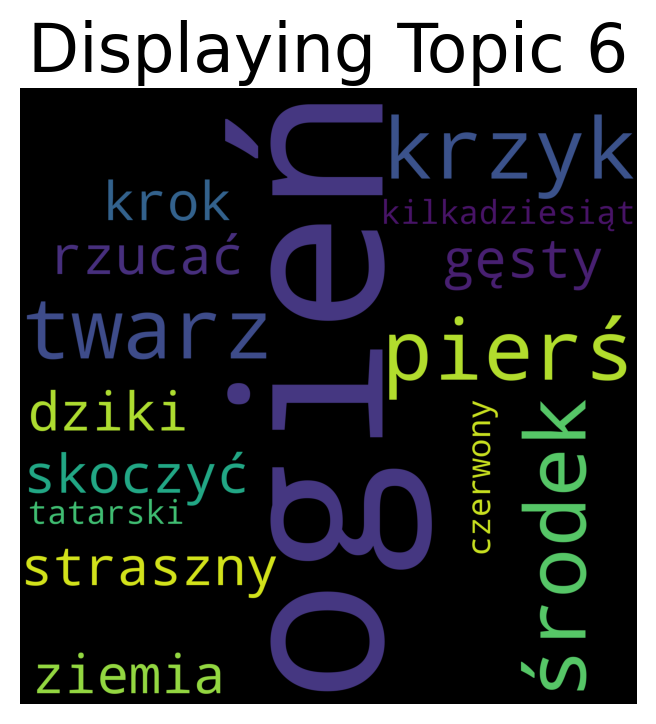

/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


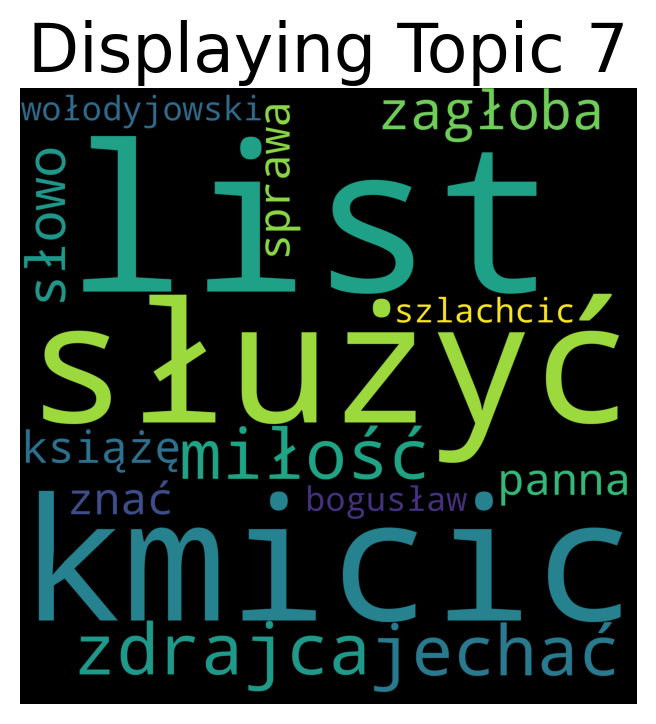

/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


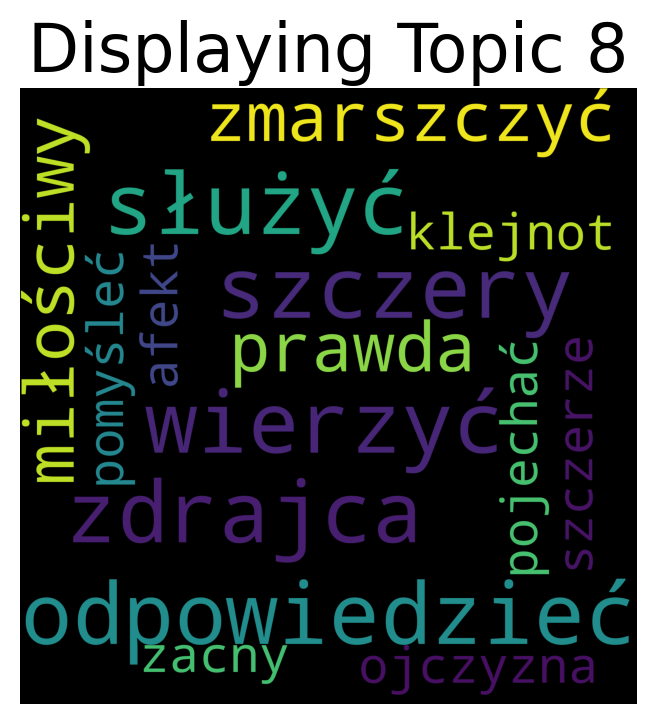

In [ ]:
for i in range(len(topics)):
  save_path = f"/content/drive/MyDrive/BigData/output/topic_{i + 1}.png"
  ctm.save_wordcloud(topic_id=i, save_path=save_path, n_words=15, background_color="black", width=2000, height=2000)


#Saving the model

In [ ]:
ctm.save(models_dir="/content/drive/MyDrive/BigData/models")

/usr/local/lib/python3.10/dist-packages/contextualized_topic_models/models/ctm.py:640: Warning: This is an experimental feature that we has not been fully tested. Refer to the following issue:https://github.com/MilaNLProc/contextualized-topic-models/issues/38
  warnings.warn(
